In [4]:
#Needed in general
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC 


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Code to prepare Figure 6 (same as for figure 4)  
run all of them 


In [23]:



''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    
AUtoRsun = 214.939

def ploteVSseparation(ax, fc, Data, dictRank, dictList, withinHubble=True):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """

    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    solar=0.0142
    LowZ = solar/10.
        
    

    for z_ind in range(2):
        weight_fast_mergers, weight_all = 0,0 
        weight_fast_mergers_10, weight_fast_mergers_0_1 = 0,0
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
            seedsInterest = dictRank[Channel]

            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]
            


            
            maskZlow = (DATAmetallicities <= LowZ)
            maskZhigh = (DATAmetallicities > LowZ)

            
            # use the cosmic integrated weights if they exist - Coen Model
            if WeightsRateIntrinsic_zIntegrated==True:

                weight = rateIntrinsic_zIntegrated
            else:
                weight = Data.weight
#             weight = Data.weight
            
            if z_ind==0:
                M1ZAMS = Data.m1zams[mask][maskZlow]
                M2ZAMS = Data.m2zams[mask][maskZlow]
                eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZlow]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZlow]
                M1 = Data.mass1[mask][maskZlow]
                M2 = Data.mass2[mask][maskZlow]    
                separationInitial = Data.separationzams[mask][maskZlow]
                weights= weight[mask][maskZlow] 
                maskZ = maskZlow
            elif z_ind==1:
                M1ZAMS = Data.m1zams[mask][maskZhigh]
                M2ZAMS = Data.m2zams[mask][maskZhigh]
                eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZhigh]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZhigh]
                M1 = Data.mass1[mask][maskZhigh]
                M2 = Data.mass2[mask][maskZhigh]   
                weights= weight[mask][maskZhigh] 
                maskZ = maskZhigh
  
            qZAMS = M2ZAMS /M1ZAMS


            
            legendlabel=None


            if len(weights):

                
                ax[z_ind].scatter((separationDCOFormation*AUtoRsun),eccentricityDCOFormation,\
                                  s=(weights*stimes_weight), edgecolor ='', linewidth=0.1,\
                                 c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])                
                


            times = Data.tc[mask][maskZ] #Myr
            maskWithin1Myr  = (times <= 1)
            
            weight_fast_mergers += np.sum(Data.weight[mask][maskZ][maskWithin1Myr])
            weight_all += np.sum(Data.weight[mask][maskZ])

            
            
            maskWithin10Myr  = (times <= 10)
            weight_fast_mergers_10 += np.sum(Data.weight[mask][maskZ][maskWithin10Myr])
               
            maskWithin0_1Myr  = (times <= .10)
            weight_fast_mergers_0_1 += np.sum(Data.weight[mask][maskZ][maskWithin0_1Myr])            
            
        # PLOT MERGER TIME SOLVER 
        x_ecc = [x_eccentricities_toneMyr, x_eccentricities_tGyr, x_eccentricities_tHubble]
        for ind_line, x_sep in enumerate([x_separation_toneMyr, x_separation_tGyr, x_separation_tHubble]):
#             print(x_sep)
#             print(x_ecc[ind_line])
#             print('-----')
            # Hubble time line
            ax[z_ind].plot((x_sep.value), x_ecc[ind_line], lw=4, color = 'k',linestyle=':', zorder=2000)        
            
            # draw arrows (see couple of cells below for how I figured out these values)
            if ind_line==0:
                strr = r"$t_{\rm{inspiral}}=1\,\rm{Myr}$"
                x_xy, y_xy = 0.31,0.7
                x_xytext, y_xytext = 0.16, 0.90 
                conn = "arc3,rad=+0.2"

            elif ind_line==1:
                strr = r"$t_{\rm{inspiral}}=1\,\rm{Gyr}$"
                x_xy, y_xy = 0.48, 0.6
                x_xytext, y_xytext = 0.82, 0.7
                conn = "arc3,rad=-0.2"

            elif ind_line==2:
                strr = r"$t_{\rm{inspiral}}=t_{\mathcal{H}}$"
                x_xy, y_xy = 0.53, 0.4
                x_xytext, y_xytext = 0.7, 0.3  
                conn = "arc3,rad=+0.2"


            ax[z_ind].annotate(strr,
              xy=(x_xy, y_xy), xycoords='axes fraction',
              xytext=(x_xytext, y_xytext), textcoords='axes fraction',
              size=14, va="center", ha="center",
        #                   bbox=dict(boxstyle="round4", fc="w"),
              arrowprops=dict(arrowstyle="-|>",
                              connectionstyle=conn,
                              fc="k", lw=2.5), zorder=20000
                          )   
                

            
#             ax.annotate(r"$t_{\rm{inspiral}}=t_{\mathcal{H}}$", xy=(0.5, 0.5), xytext=(0, 2),
#              arrowprops=dict(arrowstyle="->"), fontsize=14)
     
        
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)

        ax[z_ind].set_xlabel(xlabel2, fontsize=fs)
        ax[z_ind].set_xscale('log')

        ax[z_ind].set_xlim(.1, 10**3)
        ax[z_ind].set_ylim(0, 1) 
        
      

    
    
        # set second axes to be the Period of a 1.4 + 10 Msun binary BH-NS
        ax2y = ax[z_ind].twiny()
        
        # calculate period for 10 Msun BH and 1.4 Msun NS 
        xx_sep = np.logspace(-1,3,1000)
        Period = convert_a_to_P_circular(separation=xx_sep*u.Rsun, M1=1.4*u.Msun, M2=10*u.Msun)
        Period = Period.to(u.d)
        ax2y.set_xlim(np.min(Period.value),np.max(Period.value))
        ax2y.set_xscale('log')

        ax2y.tick_params(labelsize=fs)
        ax2y.set_xlabel(xlabel, fontsize=fs)   
        
        
        
        
        
      

        # PLOT metallicity labels 
        if z_ind==0:
            text_Z =    r'low metallicities, '+ r'$Z_{\rm{i}} \leq Z_{\odot}/10$' # 'low metallicity \n '
        elif z_ind==1:
            text_Z =    r'high metallicities, ' + r'$Z_{\rm{i}} > Z_{\odot}/10$'  #'high metallicity \n'
        
        if PlotText == True:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(text_Z, xy=(0.5, 1.08), xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='center', va="top",bbox=bbox_props)
        

        
        
        
        
    return handles, labels








In [29]:
### ''' Below I plot the ZAMS masses of the binaries forming BHNS or NSBH showing the formation channels '''


# weightsSystems =  fdata['systems']['weight'][...].squeeze()

    


def plotfinalmasses(ax, fc, Data, dictRank, dictList, withinHubble=True, BHNSorNSBH=None):
    """
    ## parameters: 
    ax: axes to plot on
    fc: formationchannels function 
    Data: Data with the target binary already specified
    dictRank: dictionary of the channels & their channel nr for all metallicities
    dictList: List with the names of the channels
    withinHubble: whether to select only DCOs that merge in a Hubble time
    """
    
    solar=0.0142
    LowZ = solar/10.
        
    maxM2ZAMSOLD, maxM1ZAMSOLD = 0,0
    for z_ind in range(2):
        

        rate_Z = np.zeros(6)
        rateALL = np.zeros(6)
        print('now at Z   %s'%metallicityLabels[z_ind])
#         mycolors = colorlist #[cm(x) for x in np.linspace(0,1 , nColors)] 
        solar = 0.0142
        log10ZZsun = np.round(np.log10(Data.metallicityGrid/solar),2)

            
            
#         Arrays_minNSmassEjecta_labels = [r'$(R_{\rm{NS}},\chi_{\rm{BH}})=11.5,0$',\
#                                          r'$(R_{\rm{NS}},\chi_{\rm{BH}})=13,0$',\
#                                          r'$(R_{\rm{NS}},\chi_{\rm{BH}})=11.5,0.5$', \
#                                          r'$(R_{\rm{NS}},\chi_{\rm{BH}})=13,0.5$']
        Arrays_minNSmassEjecta_labels = [r'$R_{\rm{NS}}=11.5\,\rm{km}, \chi_{\rm{BH}}=0$',\
                                         r'$R_{\rm{NS}}=13\,\rm{km}, \chi_{\rm{BH}}=0$',\
                                         r'$R_{\rm{NS}}=11.5\,\rm{km}, \chi_{\rm{BH}}=0.5$', \
                                         r'$R_{\rm{NS}}=13\,\rm{km},\chi_{\rm{BH}}=0.5$']
        Mej_alpha = np.linspace(0.3,0.9,4)[::-1]
        bottom = np.ones_like(BH_array)
        for ind_Mej, Mejline in enumerate(Arrays_minNSmassEjecta):
            if z_ind ==1:
                MejLabel=None
            else:
                MejLabel=Arrays_minNSmassEjecta_labels[ind_Mej] # = [r'$R_{\rm{NS}}=11.5, \chi_{\rm{BH}}=0$']
   
        
            ax[z_ind].fill_between(x=BH_array, y1=bottom, y2=Mejline, where= np.ones_like(BH_array)<=Mejline,\
                                    color='gray', label=MejLabel, alpha=Mej_alpha[ind_Mej], hatch='')
            bottom=Mejline
            

                    
        for nrC, Channel in enumerate(dictList):
            #Get the seeds that relate to sorted indices
#             seedsInterest = []
            seedsInterest = dictRank[Channel]
#             Channel_nr = Channel-1
#             for index in dictRank[Channel]:
#                 seedsInterest.extend(fc.sortedSeeds[index-1])
            #Get metallicity systems this works because seeds in both
            #files are in the same order
            mask = np.in1d(Data.seeds, np.array(seedsInterest))
            if withinHubble == True:
                mask = mask & (Data.Hubble == True)
            DATAmetallicities = Data.metallicitySystems[mask]


            
            
            maskZlow = (DATAmetallicities <= LowZ)
            maskZhigh = (DATAmetallicities > LowZ)

            
            # use the cosmic integrated weights if they exist - Coen Model
            if WeightsRateIntrinsic_zIntegrated==True:

                weight = rateIntrinsic_zIntegrated
            else:
                weight = Data.weight
#             weight = Data.weight            
            
            if z_ind==0:
#                 M1ZAMS = Data.m1zams[mask][maskZlow]
#                 M2ZAMS = Data.m2zams[mask][maskZlow]
                tc=Data.tc[mask][maskZlow]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZlow]
                M1 = Data.mass1[mask][maskZlow]
                M2 = Data.mass2[mask][maskZlow]    
                weights= weight[mask][maskZlow] 
                maskZ=maskZlow
            elif z_ind==1:
#                 M1ZAMS = Data.m1zams[mask][maskZhigh]
#                 M2ZAMS = Data.m2zams[mask][maskZhigh]
#                 eccentricityDCOFormation=Data.eccentricityDCOFormation[mask][maskZhigh]
                separationDCOFormation=Data.separationDCOFormation[mask][maskZhigh]
                M1 = Data.mass1[mask][maskZhigh]
                M2 = Data.mass2[mask][maskZhigh]   
                weights= weight[mask][maskZhigh]   
                tc=Data.tc[mask][maskZhigh]
                maskZ=maskZhigh
            
            
            weightsALL = weights.squeeze() # //floor weights    

            
            MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2) 
            
            seedsSN = fdata['supernovae']['randomSeed'][...].squeeze()
            # get only SN seeds for DCOs 
            maskSNdco = np.in1d(seedsSN,  Data.seeds[mask][maskZ]) 
            whichSN = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]
            whichSN1 = whichSN[::2] # get whichStar for first SN 
            
            
            separationPreSN = fdata['supernovae']['separationBefore'][...].squeeze()[maskSNdco]
            separationPreSN2 = separationPreSN[1::2] # in Rsun. 
            

            maskNSBH = ((whichSN1==2) & (M1>M2) ) | ((whichSN1==1) & (M1<M2) )             

   

            maskHubble = (tc<(13.7*10**3))

            ii=0
            labelMej = []
            for ind_chi, chi in enumerate([0.0, .5, 'Qin']):
                if chi=='Qin':
                    # Qin 2018 spin model 
                    BH_chi = QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH)
                else:    
                    BH_chi   = chi * np.ones_like(MNS)
                
                for ind_Rns, NSradii in enumerate([11.5,13.0]):
                    Rns = NSradii
                    NS_radii = Rns * np.ones_like(MNS)

                    Mej = calculateEjectedMassMerger(m_ns=MNS, r_ns=NS_radii, m_bh=MBH, Xeff=BH_chi)

                    maskEjecta = (Mej > 0)
                    
                    rate_Z[ii]+= np.sum(weightsALL[maskEjecta])
                    labelMej.append('chi = ' + str(chi) + ' Rns = ' + str(NSradii) +' km')
                    ii+=1
                    


            
            
            
            rateALL+=np.sum(weightsALL)
            
            if z_ind==1: # only legendlabel in one of 2 metallicity plots
                legendlabel=Channel
            else:
                legendlabel=None

            ax[z_ind].scatter(MBH, MNS, s=(weightsALL*stimes_weight), edgecolor ='', linewidth=0.1,\
             c=colorlist[nrC],label =legendlabel, zorder=zorderlist[Channel])


            
        if z_ind==0:
            
            ax[z_ind].set_ylabel(ylabel, fontsize=fs)
#             ax[z_ind].tick_params(which='both', width=2)
            
        ax[z_ind].yaxis.set_minor_locator(AutoMinorLocator())
        ax[z_ind].xaxis.set_minor_locator(AutoMinorLocator())
        
        ax[z_ind].tick_params(labelsize=fs)
#         ax[z_ind].grid(True, which='major');

        ax[z_ind].set_xlabel(xlabel, fontsize=fs)
        
        
        ax[z_ind].tick_params(labelsize=fs)

        # PLOT metallicity labels 
        if z_ind==0:
            text_Z =    r'low metallicities, '+ r'$Z_{\rm{i}} \leq Z_{\odot}/10$' # 'low metallicity \n '
        elif z_ind==1:
            text_Z =    r'high metallicities, ' + r'$Z_{\rm{i}} > Z_{\odot}/10$'  #'high metallicity \n'
        
        if PlotText == True:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(text_Z, xy=(0.5, 1.1), xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='center', va="top",bbox=bbox_props)
  
        
#         bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75)
#         ax[z_ind].annotate(r'$Z = %s$'%chosenMetallicity, xy=(0.05, 0.95), xycoords='axes fraction', fontsize = fs, weight = 'bold', va="top",bbox=bbox_props, zorder=100)

        
        if z_ind ==1:  
            if LOOP ==False:
                ax[z_ind].set_xlim(2.5, 20)
                ax[z_ind].set_ylim(1.2, 2.5)
            else:
                ax[z_ind].set_xlim(2.0, 45)
                ax[z_ind].set_ylim(1., 3)                
            handles, labels = ax[z_ind].get_legend_handles_labels() 
        if z_ind ==0:    
            if LOOP==False:
                ax[z_ind].set_xlim(2.5, 35)
                ax[z_ind].set_ylim(1.2, 2.5)
            else:
                ax[z_ind].set_xlim(2.0, 45)
                ax[z_ind].set_ylim(1., 3)                        
            f.legend(fontsize=20, frameon=False, bbox_to_anchor=(.8, 1.13), ncol=2, markerscale=3.)
#             legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
#          bbox_to_anchor=(.9, 1.09),  markerscale=3., scatterpoints=1) # loc = 'upper center')

            
        if (LOOP == True) & (z_ind==0):
            
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
            ax[z_ind].annotate(r'\textbf{model %s:}'%(bps_model) +'\n' + alphabetPhysicalNameDict[bps_model], xy=(0.042, .95),\
                         xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                        zorder=1E10)



        print()
        print('for Z=',text_Z, 'we find rates with Mej of: ')
        for ii, lab in enumerate(labelMej):
            
            print(lab, ' = ',   np.asarray(rate_Z[ii])/np.asarray(rateALL[0]))
        
        
        
    return handles, labels








# create Figure 6

## load and prepare Data 

In [7]:
# path to hdf5 file (which I pass to the formationChannel file later)
# in this case we want to show the results for the fiducial binary population synthesis model for BHNS mergers,
# this file is called 'COMPASCompactOutput_BHNS_A.h5' and given in Zenodo. For you the path '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial' will likely be different
# and be instead the folder where you downloaded the data
pathCOMPASOutput = '/Volumes/Andromeda/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_BHNS_A.h5'

fdata = h5.File(pathCOMPASOutput)
print(fdata.keys())

<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems', 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift']>


In [8]:




#### Fiducial 
MODEL = 'Fiducial'




# fc = FC.FormationChannels(path = pathCOMPASOutput)
# fc.formationChannelsSeeds(types='BHNS', withinHubbleTime=True, optimistic=False)
#Based on previous notes I already now the ranks and channels


#But I want only within Hubble time 
Data            = CC.COMPASData(path=pathCOMPASOutput, lazyData=True, Mlower=5., \
                 Mupper=150., binaryFraction=1)
Data.setCOMPASDCOmask(types='BHNS',  withinHubbleTime=True, optimistic=False)
Data.setCOMPASData()
SeedsHubble    = Data.seeds[Data.Hubble==True]






weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


In [9]:

# calculate the uncertainty on the rate from poisson scatter: 
print('total weight BHNS mergers in COMPAS simulation =', np.sum(Data.weight))
rate = np.sum(Data.weight)
Nzeros = int(53*1E6 - len(Data.weight))
all_weights = np.concatenate((np.zeros(Nzeros), Data.weight))
var_rate = np.std(all_weights, ddof=1) * np.sqrt(1E6)

print('fractional uncertainty on total weight BH-NS =', var_rate/rate)
print('percentage uncertainty on total weight BH-NS =', 100*var_rate/rate, '%')

print('STROOPWAFEL gain =', len((Data.weight))/np.sum(Data.weight))

# metallicities 
DATAmetallicities = Data.metallicitySystems

# size to multiply the scatterpoint area with
stimes_weight = 200


total weight BHNS mergers in COMPAS simulation = 23174.234060106566
fractional uncertainty on total weight BH-NS = 0.00025328472928200175
percentage uncertainty on total weight BH-NS = 0.025328472928200178 %
STROOPWAFEL gain = 65.82970535480061


# calculate the formation channels that the BH-NS form through. 

In [10]:
# obtain the seeds of the BHNS for each channel

seedsPercentageClassic, seedsPercentageOnlyStableMT = returnSeedsPercentageClassicAndOnlyStableMT(pathCOMPASOutput=pathCOMPASOutput,\
                                types='BHNS',  withinHubbleTime=True, optimistic=False, \
                                binaryFraction=1)
seedsClassic, percentageClassic = seedsPercentageClassic
seedsOnlyStableMT, percentageOnlyStableMT = seedsPercentageOnlyStableMT



seedsDoubleCE, percentageDoubleCE = returnSeedsPercentageDoubleCoreCEE(pathCOMPASOutput=pathCOMPASOutput,\
                                types='BHNS',  withinHubbleTime=True, optimistic=False, \
                                binaryFraction=1)


seedsSingleCE, percentageSingleCE = returnSeedsPercentageSingleCoreCEE(pathCOMPASOutput=pathCOMPASOutput,\
                                types='BHNS',  withinHubbleTime=True, optimistic=False, \
                                binaryFraction=1)



seedschannels = [seedsClassic, seedsOnlyStableMT, seedsSingleCE, seedsDoubleCE]

seedsOther, percentageOther = returnSeedsPercentageOther(pathCOMPASOutput=pathCOMPASOutput,\
                                types='BHNS',  withinHubbleTime=True, optimistic=False, \
                                binaryFraction=1, channelsSeedsList=seedschannels)




dictChannelsBHNS = { 'classic':seedsClassic, \
                    'immediate CE':seedsSingleCE,\
                         'stable B no CEE':seedsOnlyStableMT, \
                     r'double-core CE':seedsDoubleCE,  \
                        'other':seedsOther\
                       }


dictPercentages = { 'classic':percentageClassic, \
                    'immediate CE':percentageSingleCE,\
                         'stable B no CEE':percentageOnlyStableMT, \
                     r'double-core CE':percentageDoubleCE,  \
                        'other':percentageOther\
                       } 

weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[maskInterest]


percentage Classic        =  65.18201235140664
percentage Only stable MT =   5.081141190979925
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage double core CE channel = 3.36936747652693
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:534: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage single core CE channel = 19.67088471620494
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()
percentage other channel =  6.696594264881554


In [11]:
# prepare legend label:


legendlabel = []
for ind, key in enumerate(dictChannelsBHNSList):
    
    print(str((round(dictPercentages[key],2))) + str(r'\%'))
    string = dictChannelsBHNSListBolt[ind] #+# ' '# + r'$%s$'%str((roundAndFormat1(dictPercentages[key]))) + str(r'\%')
    print(string)
    legendlabel.append(string)
    
    


65.18\%
\textbf{(I) Classic}
5.08\%
\textbf{(II) Only stable mass transfer}
19.67\%
\textbf{(III) Single-core CE as first mass transfer}
3.37\%
\textbf{(IV) Double-core CE as first mass transfer}
6.7\%
\textbf{(V) Other}


## some functions for merger time and period calculations

In [13]:
def timeToCoalescenceUsingInterpolation( a0,  e0,  m1,  m2):
    """/*
     Calculate the time to coalescence for a binary with arbitrary eccentricity using interpolation

     This is Equation 5.14 in Peters 1964 http:#journals.aps.org/pr/pdf/10.1103/PhysRev.136.B1224

     Parameters
     -----------
     a0 : 
        Initial semi-major axis in SI units
     e0 : 
        Initial eccentricity
     m1 :  
        Primary mass in SI units
     m2 : 
        Secondary mass in SI units

     Returns
     --------
     t_coalesce : 
        Time to coalescence in SI units (s)

     */
    """
    # Declare some variables
    tc       = 0.0;                                          # Time for a circular binary to coalesce
    beta     = 0.0;                                          # Beta constant (function of masses)
    tovertc  = 0.0;                                          # Result of interpolation of t/tc function


    # Calculate circular time to coalescence
    beta = calculateBeta(m1, m2);                                   # Masses should be in SI
    tc = a0*a0*a0*a0/(4.0*beta);                                    # Calculate time for a circular binary to merge

    # calculate t/tc using the interpolated function
    #tovertc = polynomialFitToToverTc(e0);                           # Ratio of inspiral time to that of circular system
    if((e0==0.0)or(e0==0)):
        return	tc;

    c0=a0*(1.0-e0*e0)*np.power(e0,-12.0/19.0)*np.power(1.0+(121.0*e0*e0/304.0), -870.0/2299.0);


    if(e0<0.01): 
        return c0*c0*c0*c0*np.power(e0,48.0/19.0)/(4.0*beta);


    if(e0>0.99):
        # Approximation of eq. 5.14 of Peters 1964, for high eccentricities
        return (768.0/425.0)*tc*np.power((1.0-(e0*e0)),3.5);

    # otherwise: numerically integrate
    summ=0;
    de=e0/10000;
    e=0
    while(e<e0):
        summ=summ+de*np.power(e,29.0/19.0)*np.power((1.0+(121.0/304.0)*e*e),1181.0/2299.0)/np.power((1-e*e),1.5);
        e=e+de

    return 12.0/19.0*c0*c0*c0*c0/beta*summ;



def calculateBeta( m1,  m2):
    """/*
     # Calculate the constant beta based on masses as defined in Equation 5.9 in Peters 1964 http:#journals.aps.org/pr/pdf/10.1103/PhysRev.136.B1224
     
     Parameters
     -----------
     m1 : float
        Primary mass in SI units
     m2 : float
        Secondary mass in SI units
     
     Returns
     --------
     beta : float
        Mass parameter beta
 
     */
     """
    M = m1 + m2;

    return (64.0/5.0)*G*G*G*m1*m2*M*np.power(c,-5.0);



In [14]:



def create_adaptive_separationArray(xstart,xend, Niter_a1, Niter_a2, Niter_a3):

    x_sep1 = np.logspace(-1.1, xstart, Niter_a1)
    x_sep2 = np.logspace(xstart*1.0001, xend, Niter_a2)
    x_sep3 = np.logspace(xend*1.0001, 3, Niter_a3)

    
    x_separation = np.concatenate((x_sep1, x_sep2))
    x_separation = np.concatenate((x_separation, x_sep3))
    
    x_separation = x_separation*u.R_sun # array of separations to try
    
    return x_separation
    




def obtain_a_and_e_for_fixed_mergerTime(x_separation, fixed_Tinsp, Niter_a, Niter_e):
    """ 
    
    fixed_Tinsp = wanted merger time in yrs
    
    """
    # constants
    M1 = 10*u.M_sun
    M2 = 1.4*u.M_sun
    c= const.c.si
    G = const.G.si
    ##
    if x_separation==None:
        x_separation = np.logspace(-1, 3, Niter_a)*u.R_sun # array of separations to try
    x_eccentricities = [] # list where we will append the solution of the eccentricities 

    emin =0
    for ind_a, sep in enumerate(x_separation):
        
        for ind_e, ecc in enumerate(np.linspace(emin, 1, Niter_e)):
            mergertime = timeToCoalescenceUsingInterpolation(a0=sep.to(u.meter), e0=ecc, m1=M1.to(u.kg),  m2=M2.to(u.kg)).to(u.year) # in years
            if (mergertime <= fixed_Tinsp) | (ecc==1):
                x_eccentricities.append(ecc)
                emin = ecc

                break 
    
    return x_eccentricities


Niter = 1000

a =10**(2)*u.R_sun
M1 = 10*u.M_sun
M2 = 1.4*u.M_sun

c= const.c.si
G = const.G.si
Niter_a, Niter_e = 20,20
t_Hubble = 13.7*u.Gyr
t_Hubble_inyears = (t_Hubble.to(u.year))
req_times_list_names = ['thousandYr' ,'oneMyr', 'oneGyr', 'tHubble' ]
BH_array = np.linspace(2.5, 20, Niter)


for ind_n, name_t in enumerate(req_times_list_names):

    TIME=name_t #'oneMyr'#'thousandYr'  #'tHubble'  #'tenMyr' #

    DEFAULT=False
    if DEFAULT==True:
        t_requested =  (1e6*u.year).to(u.year) #t_Hubble_inyears #(10*u.Myr).to(u.year) # in years
        
        
    if DEFAULT==True:
        x_separation = np.logspace(-1, 3, Niter_a)*u.R_sun # array of separations to try
        x_eccentricities = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=20)




    else:
        if TIME=='tHubble':
            xstart, xend = 0.8, 1.8
            x_separation_tHubble = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_tHubble

            x_eccentricities_tHubble = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_Hubble_inyears, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_tHubble

        elif TIME=='oneGyr':
            t_requested = (1*u.Gyr).to(u.year)
            xstart, xend = np.log10(4), np.log10(50)


            x_separation_tGyr = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_tGyr

            x_eccentricities_tGyr = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_tGyr

        elif TIME=='tenMyr':
            t_requested = (10*u.Myr).to(u.year)
            xstart, xend = np.log10(1), np.log10(20)


            x_separation_tTenMyr = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_tTenMyr

            x_eccentricities_tTenMyr = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_tTenMyr        


        elif TIME=='oneMyr':
            t_requested = (1*u.Myr).to(u.year)
            xstart, xend = np.log10(.6), np.log10(4)


            x_separation_toneMyr = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_toneMyr

            x_eccentricities_toneMyr = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_toneMyr  



        elif TIME=='thousandYr':
            t_requested = (1000*u.year).to(u.year)
            xstart, xend = np.log10(.101), np.log10(.6)


            x_separation_thousandYr  = create_adaptive_separationArray(xstart,xend, Niter_a1=10, Niter_a2=50, Niter_a3=30)
            x_separation=x_separation_thousandYr 

            x_eccentricities_thousandYr  = obtain_a_and_e_for_fixed_mergerTime(x_separation=x_separation, fixed_Tinsp=t_requested, Niter_a=20, Niter_e=50)
            x_eccentricities=x_eccentricities_thousandYr        


        else:
            print('error time not known')






In [ ]:



def convert_a_to_P_circular(separation, M1, M2):
    """calculate Period from separation
    separation is separation (needs to be given in astropy units)
    M1 and M2 are masses of the binary
    
    """
    G = const.G # [gr cm s^2]
    

    mu = G*(M1+M2)
    period = 2*np.pi * np.sqrt(separation**3/mu)
    
    
    
    return period

if testing==True:
    Period = convert_a_to_P_circular(separation=1*u.Rsun, M1=1*u.Msun, M2=1*u.Msun)

    print(Period.to(u.d))

In [17]:



def calculateRisco(m_bhtemp, Xefftemp):
    # this is prograde orbit
    # see also https://duetosymmetry.com/tool/kerr-isco-calculator/

    # everything in cgs
    c = 2.99792458E10 #[cm s-1] 
    G = 6.67259E-8   
    Msun = 1.99E33 # gr
    Rsun = 6.96E10 # cm     
    
    factorFront =   ((G*m_bhtemp)/c**2) #m_bhtemp #s
    
    Z1 = 1 + (1 - Xefftemp**2)**(1/3) * ((1 + Xefftemp)**(1/3) + (1 - Xefftemp)**(1/3) )
    Z2 = np.sqrt((3* Xefftemp**2 + Z1**2))
    
    Risco = factorFront * (3 + Z2 - np.sqrt((3-Z1)*(3+Z1 +2*Z2)))
    return Risco



def calculateEjectedMassMerger(m_ns, r_ns, m_bh, Xeff ):
 # from 1807.00011, Eq 4 
    # returns M_rem in solar masses 
    # input r and m in solar masses and R sun. Xeff in [0,1] (symmetric) 
    # RNS in km
    
    
    # everything in cgs
    c = 2.99792458E10 #[cm s-1] 
    G = 6.67259E-8   
    Msun = 1.99E33 # gr
    Rsun = 6.96E10 # cm         
    
    
    # convert to cgs
    r_ns  = r_ns*0.1*10**6 #np.asarray([1.E6]* len(m_ns)) # to cm
    m_ns_cgs = Msun * m_ns
    m_bh_cgs = Msun * m_bh
    
    
    alpha, beta, gamma, delta = 0.406, 0.139, 0.255, 1.761
    C_NS = G * m_ns_cgs / (r_ns * c**2)
    
    R_isco = calculateRisco(m_bh_cgs, Xeff)
    
    R_isco_norm  = R_isco / (m_bh_cgs * (G/c**2)) 
    
    Q = m_bh_cgs / m_ns_cgs
    
    eta = Q / (1 + Q)**2
    
    FirstTerm  = alpha*(1 - 2*C_NS) / eta**(1/3)
    SecondTerm = beta* R_isco_norm * C_NS / eta 
    
    A = np.asarray(FirstTerm - SecondTerm + gamma)
    B = np.zeros_like(m_ns_cgs)
    
    Mrem_model = np.maximum(A,B)**(delta)
    
    Mrem_model /= Msun # in solar masses 
    
    # and the true M remnant mass (not normalized and in solar masses =)
    Mrem_solar = Mrem_model * m_ns_cgs  
    return Mrem_solar # in [Msun]

Rns = 11.5 # in km 
# r_ns = np.asarray([Rns]*len(m1bh))
# for ind_chi, chi_bh in enumerate(listXbh):




NSmasses = np.linspace(1,2.5,10000)
Niter = 1000
# BH_chi = 0
Arrays_minNSmassEjecta = [] # _Rns11chi0 _Rns13chi0 Rns11chi1 Rns13chi1
for ind_chi, chi in enumerate([0.0, .5]):
    BH_chi   = chi * np.ones_like(NSmasses)
    for ind_Rns, NSradii in enumerate([11.5,13.0]):
        Rns = NSradii
#         BH_chi=chi
        minNSmassEjecta = []
        for ind_bh, BHmass in enumerate(np.linspace(2.5, 20, Niter)):

            BHmasses = BHmass*np.ones_like(NSmasses)
            NS_radii = Rns * np.ones_like(NSmasses)
            
            Mej = calculateEjectedMassMerger(m_ns=NSmasses, r_ns=NS_radii, m_bh=BHmasses, Xeff=BH_chi)

            maskEjecta = (Mej > 0)
            # if there are solutions with Mej >0, append the first solution (with min BH mass)
            if len(NSmasses[maskEjecta]):
                minNSmassEjecta.append(NSmasses[maskEjecta][-1])
        #         print(minNSmassEjecta[-1])
            else:
                minNSmassEjecta.append(-1) # just append a non physical value that should not show up on plot

        Arrays_minNSmassEjecta.append(minNSmassEjecta)
    
    

Arrays_minNSmassEjecta_labels = [r'$R_{\rm{NS}}=11.5, \Chi_{\rm{BH}}=0']

In [18]:
def QinBHspinmodel(separationPreSN2, M1, M2, maskNSBH):
    # returns spins from Qin et al + 2018 model 
    
    # start with all zeseparationDCOFormationarationDCOFormationBH spins
    BHspins = np.zeros_like(separationPreSN2)
    
    # now add spins for NS-BH following Qin et al 2018:
    # this is based on the separation prior to the second SN  
    PeriodPreSN2 = convert_a_to_P_circular(separation=separationPreSN2*u.Rsun, M1=M1*u.Msun, M2=M2*u.Msun)
    PeriodPreSN2 = PeriodPreSN2.to(u.d).value # in days 
    
    # only do non zero spins
    # first mask super tight NSBH that will get spin 1
    maskNSBHChi1 = (np.log10(PeriodPreSN2) < -0.3) & (maskNSBH ==1)
    BHspins[maskNSBHChi1] = np.ones(np.sum(maskNSBHChi1)) # fill with ones
#     print('#total, = ', len(maskNSBHChi1))
#     print('# with Chi = 1, = ', np.sum(maskNSBHChi1))
    
    # now the variable spin
    maskNSBHChi_var = (np.log10(PeriodPreSN2) > -0.3) &  (np.log10(PeriodPreSN2) < 0.3)  &(maskNSBH ==1)
    m_, c_ = -5./3, 0.5 # from Qin + 2018 
    spins_var =  m_ * np.log10(PeriodPreSN2[maskNSBHChi_var])  + c_   
    BHspins[maskNSBHChi_var] = spins_var
#     print('# with Chi var = ', np.sum(maskNSBHChi_var))
    
    return BHspins
    
    
    
    
    
    

## Plot the figure from the data  

now at Z   \leq 0.01


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:165: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



for Z= low metallicities, $Z_{\rm{i}} \leq Z_{\odot}/10$ we find rates with Mej of: 
chi = 0.0 Rns = 11.5 km  =  0.031070127144891657
chi = 0.0 Rns = 13.0 km  =  0.06121447944672317
chi = 0.5 Rns = 11.5 km  =  0.11321283212809202
chi = 0.5 Rns = 13.0 km  =  0.21164850258399723
chi = Qin Rns = 11.5 km  =  0.09606133863967847
chi = Qin Rns = 13.0 km  =  0.1311858419076007
now at Z   > 0.01

for Z= high metallicities, $Z_{\rm{i}} > Z_{\odot}/10$ we find rates with Mej of: 
chi = 0.0 Rns = 11.5 km  =  0.025650281137584982
chi = 0.0 Rns = 13.0 km  =  0.072649740327663
chi = 0.5 Rns = 11.5 km  =  0.1786352709016015
chi = 0.5 Rns = 13.0 km  =  0.33105744607646015
chi = Qin Rns = 11.5 km  =  0.03778529229836582
chi = Qin Rns = 13.0 km  =  0.08551744676797121


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


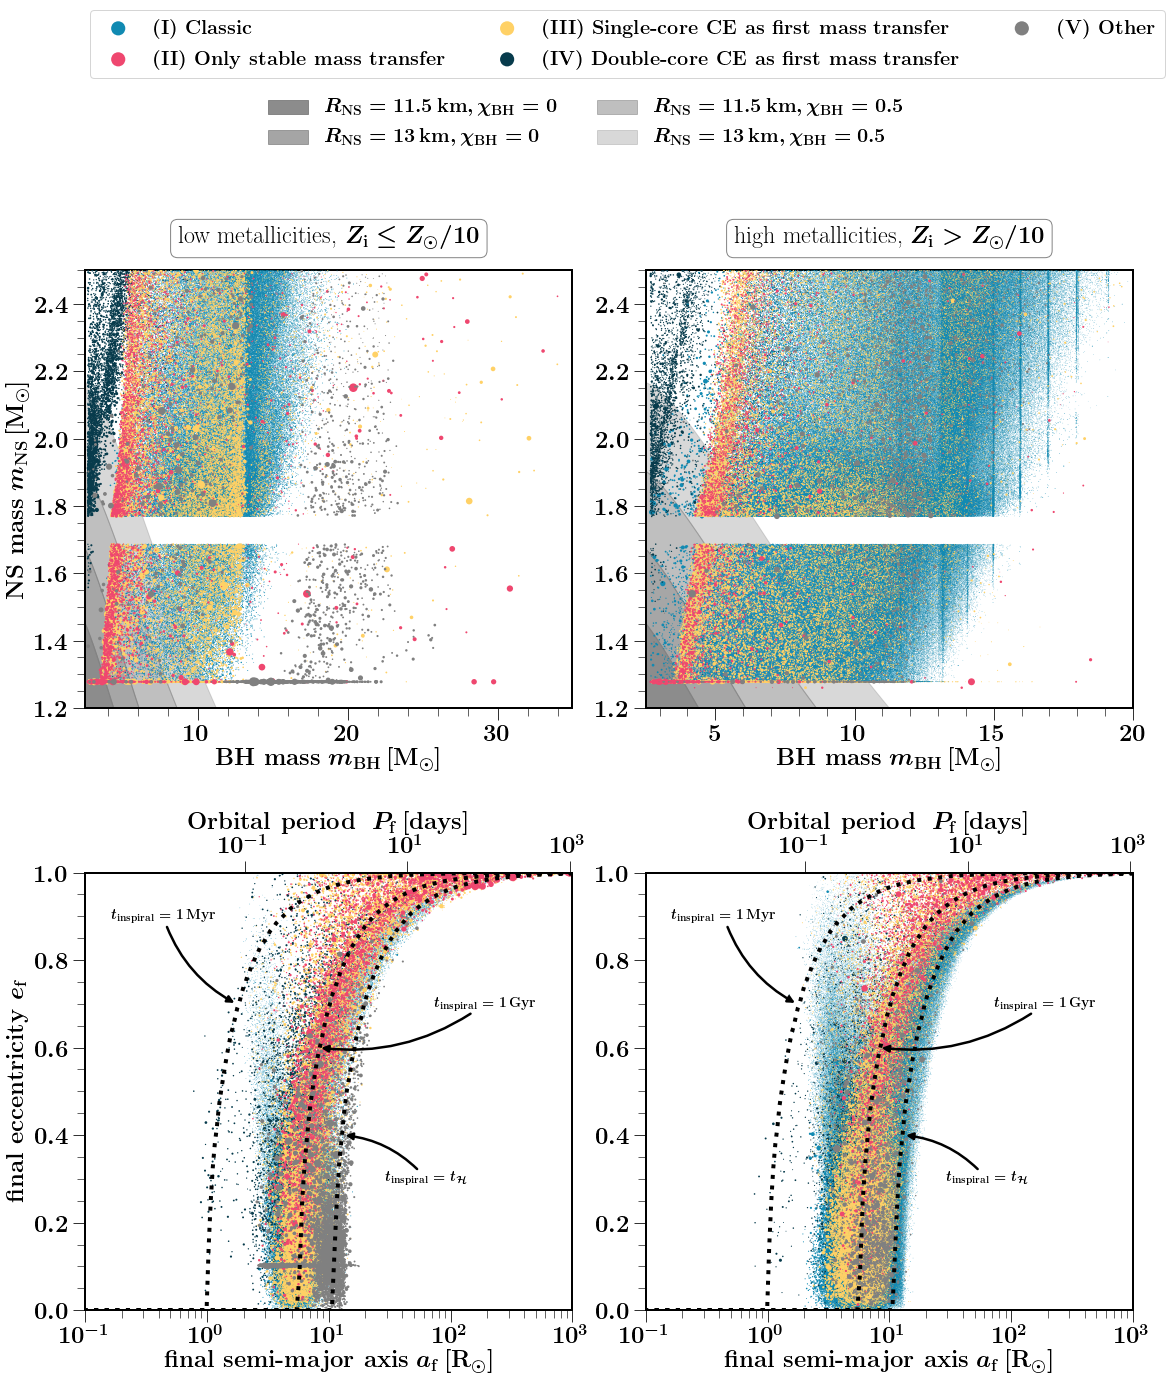

In [25]:


LOOP = False

# Use MSSFR Integrated weights?
WeightsRateIntrinsic_zIntegrated=False
if WeightsRateIntrinsic_zIntegrated==False:
    ModelName = 'notMSSFRweighted'

# multiply weights with this no to obtain scatter point area size
stimes_weight = 25



# Niter = 1000
# BH_array = np.linspace(2.5, 20, Niter)

ModelName = 'notMSSFRweighted'
stimes_weight = 25
metallicities = [0.0014,  0.01269]
metallicityLabels = ['\leq 0.01', '> 0.01']

WeightsRateIntrinsic_zIntegrated=False
# stimes_weight = 7

fc=None

f, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})



################ TOP PANELS ##########
    

xlabel = r'\textbf{BH mass} $m_{\rm{BH}} \, [\rm{M}_{\odot}]$'
ylabel = r'\textbf{NS mass} $m_{\rm{NS}} \, [\rm{M}_{\odot}]$'
PlotText=True
handles, labels = plotfinalmasses(ax=ax[0], fc=fc, Data=Data\
                  , dictRank=dictChannelsBHNS, \
              dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='BHNS')




## Add Channel Legend to the plot
# with percentages 
lgd2 = f.legend(handles, legendlabel, fontsize=20, ncol=3,\
         bbox_to_anchor=(1.02, 1.20),  markerscale=3., scatterpoints=1) # loc = 'upper center')
# without percentages channel 
# lgd2 = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
#          bbox_to_anchor=(.99, 1.15),  markerscale=3., scatterpoints=1) # loc = 'upper center')

markersize_lgd = 200
lgd2.legendHandles[0]._sizes = [markersize_lgd]
lgd2.legendHandles[1]._sizes = [markersize_lgd]
lgd2.legendHandles[2]._sizes = [markersize_lgd]
lgd2.legendHandles[3]._sizes = [markersize_lgd]
lgd2.legendHandles[4]._sizes = [markersize_lgd]





############ BOTTOM PANELS ################
xlabel = r' \textbf{Orbital period } $P_{\rm{f}} \, [\rm{days}]$' #\rm{R}_{\odot}
ylabel = r'\textbf{final eccentricity $e_{\rm{f}}$} '
xlabel2 = r' \textbf{final semi-major axis} $a_{\rm{f}} \, [\rm{R}_{\odot}]$'

PlotText=False 
_,_ = ploteVSseparation(ax=ax[1], fc=None, Data=Data\
                  , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


#########################################


# FINALIZING PLOT:

f.tight_layout(pad=0.4, w_pad=0.5, h_pad=4) 
# plt.subplots_adjust(hspace=.8)
# print(ModelName)
f.savefig('./BHNS_FinalParam_BugFix_'+ModelName +'.png', bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi=600)
plt.show()
plt.close()        





### Code used to play around with positions of arrows:

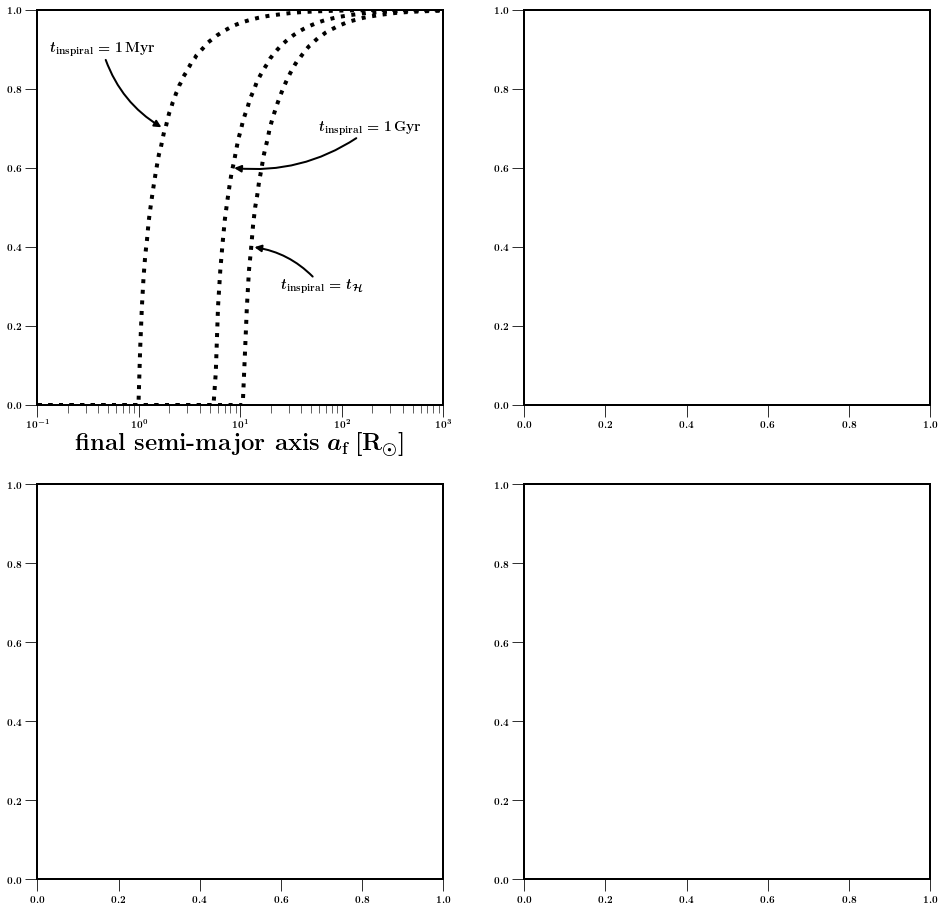

In [26]:
fig, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                  gridspec_kw={"width_ratios":[1.5, 1.5]})


x_ecc = [x_eccentricities_toneMyr, x_eccentricities_tGyr, x_eccentricities_tHubble]
for ind_line, x_sep in enumerate([x_separation_toneMyr, x_separation_tGyr, x_separation_tHubble]):

    ax[0,0].plot((x_sep.value), x_ecc[ind_line], lw=4, color = 'k',linestyle=':', zorder=2000)        


    if ind_line==0:
        strr = r"$t_{\rm{inspiral}}=1\,\rm{Myr}$"
        x_xy, y_xy = 0.31,0.7
        x_xytext, y_xytext = 0.16, 0.90 
        conn = "arc3,rad=+0.2"

    elif ind_line==1:
        strr = r"$t_{\rm{inspiral}}=1\,\rm{Gyr}$"
        x_xy, y_xy = 0.48, 0.6
        x_xytext, y_xytext = 0.82, 0.7
        conn = "arc3,rad=-0.2"

    elif ind_line==2:
        strr = r"$t_{\rm{inspiral}}=t_{\mathcal{H}}$"
        x_xy, y_xy = 0.53,0.4
        x_xytext, y_xytext = 0.7, 0.3  
        conn = "arc3,rad=+0.2"


    ax[0,0].annotate(strr,
      xy=(x_xy, y_xy), xycoords='axes fraction',
      xytext=(x_xytext, y_xytext), textcoords='axes fraction',
      size=14, va="center", ha="center",
#                   bbox=dict(boxstyle="round4", fc="w"),
      arrowprops=dict(arrowstyle="-|>",
                      connectionstyle=conn,
                      fc="k", lw=2), zorder=1E10
                  )      
ax[0,0].set_xlabel(xlabel2, fontsize=fs)
ax[0,0].set_xscale('log')

ax[0,0].set_xlim(.1, 10**3)
ax[0,0].set_ylim(0, 1)               

plt.show()


# Make additional figures for online supplementary 

In [27]:
import string

# some label lists for different models 
nModels=15
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
# I put every data file in an own directory, with the following names: 
modelDirList = ['fiducial', 'massTransferEfficiencyFixed_0_25', 'massTransferEfficiencyFixed_0_5', 'massTransferEfficiencyFixed_0_75', \
               'unstableCaseBB', 'alpha0_5', 'alpha2_0', 'fiducial', 'rapid', 'maxNSmass2_0', 'maxNSmass3_0', 'noPISN',  'ccSNkick_100km_s', 'ccSNkick_30km_s', 'noBHkick' ]

alphabetDirDict =  {BPSnameslist[i]: modelDirList[i] for i in range(len(BPSnameslist))}


physicalNamesBPSmodels = [r'\textbf{fiducial}',\
                           r'$\beta=0.25$', r'$\beta=0.5$',  r'$\beta=0.75$',r'\textbf{unstable case BB}',\
                           r'$\alpha_{\rm{CE}}=0.5$',  r'$\alpha_{\rm{CE}}=2$', r'\textbf{optimistic CE}',\
                          r'\textbf{rapid SN}', r'$\rm{max} \ m_{\rm{NS}}=2.0\,\rm{M}_{\odot}$', r'$\rm{max} \ m_{\rm{NS}}=3.0\,\rm{M}_{\odot}$',\
                          r'\textbf{no PISN}', r'\textbf{SN} '+ r'$\sigma_{\rm{cc}}=100\,\rm{km}\,\rm{s}^{-1}$',r'\textbf{SN} '+ r'$\sigma_{\rm{cc}}=30\,\rm{km}\,\rm{s}^{-1}$',\
                          r'\textbf{SN} '+ r'$v_{\rm{k,BH}}=0\,\rm{km}\,\rm{s}^{-1}$' ]



alphabetPhysicalNameDict =  {BPSnameslist[i]: physicalNamesBPSmodels[i] for i in range(len(BPSnameslist))}

# Loop over all binary population synthesis models: 


-----------------
now doing BPS model A, fiducial
now getting Data)
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()
total weight BHNS mergers in COMPAS simulation = 23174.234060106566
fractional uncertainty on total weight BH-NS = 0.00025328472928200175
percentage uncertainty on total weight BH-NS = 0.025328472928200178 %
STROOPWAFEL gain = 65.82970535480061
now calculating formation channels
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[maskInterest]


percentage Classic        =  65.18201235140664
percentage Only stable MT =   5.081141190979925
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage double core CE channel = 3.36936747652693
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:534: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage single core CE channel = 19.67088471620494
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()
percentage other channel =  6.696594264881554
now at Z   \leq 0.01


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:165: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



for Z= low metallicities, $Z_{\rm{i}} \leq Z_{\odot}/10$ we find rates with Mej of: 
chi = 0.0 Rns = 11.5 km  =  0.031070127144891657
chi = 0.0 Rns = 13.0 km  =  0.06121447944672317
chi = 0.5 Rns = 11.5 km  =  0.11321283212809202
chi = 0.5 Rns = 13.0 km  =  0.21164850258399723
chi = Qin Rns = 11.5 km  =  0.09606133863967847
chi = Qin Rns = 13.0 km  =  0.1311858419076007
now at Z   > 0.01

for Z= high metallicities, $Z_{\rm{i}} > Z_{\odot}/10$ we find rates with Mej of: 
chi = 0.0 Rns = 11.5 km  =  0.025650281137584982
chi = 0.0 Rns = 13.0 km  =  0.072649740327663
chi = 0.5 Rns = 11.5 km  =  0.1786352709016015
chi = 0.5 Rns = 13.0 km  =  0.33105744607646015
chi = Qin Rns = 11.5 km  =  0.03778529229836582
chi = Qin Rns = 13.0 km  =  0.08551744676797121


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


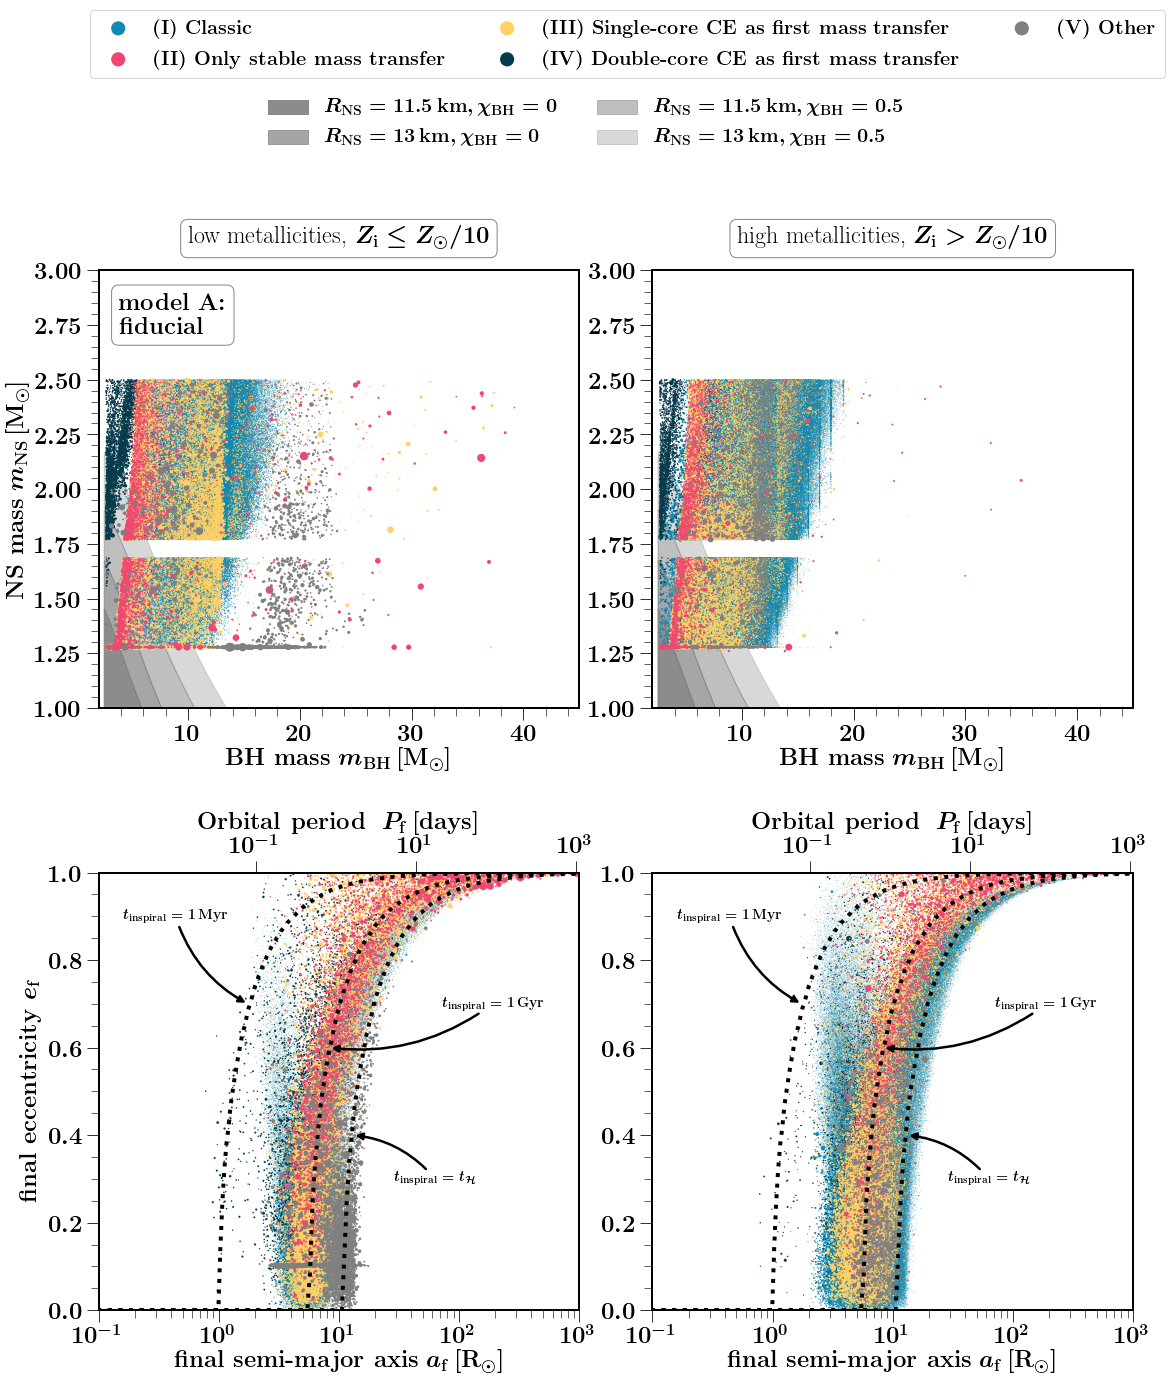

finished, figure is saved in the directory supplementary_material/

-----------------
now doing BPS model B, massTransferEfficiencyFixed_0_25
now getting Data)
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()
total weight BHNS mergers in COMPAS simulation = 15581.352363435695
fractional uncertainty on total weight BH-NS = 0.00035310477755190695
percentage uncertainty on total weight BH-NS = 0.035310477755190695 %
STROOPWAFEL gain = 47.39877404564081
now calculating formation channels
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[maskInterest]


percentage Classic        =  56.83293974289229
percentage Only stable MT =   16.867928898491922
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


percentage double core CE channel = 0.0
weighted samples :-D
Remember to  self.setCOMPASDCOmask() and self.setCOMPASData()


../../Scripts/ClassFormationChannels_5mainchannels.py:534: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  seedsRemain       = f['RLOF']['randomSeed'][...].squeeze()[RLOF_Z_MASK][maskInterest]


In [ ]:
mainpath = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'

# I want figure for BHNS binaries
DCOtype='BHNS'


for ind_bps, bps_model in enumerate(BPSnameslist):

    
    print()
    print('-----------------')
    print('now doing BPS model %s, %s'%(bps_model, alphabetDirDict[bps_model]))



    
    
    # get fdata from path to this particularly bps file based on how I named the different models
    path = mainpath + str(alphabetDirDict[bps_model]) + '/COMPASCompactOutput_' + DCOtype +'_' + bps_model +'.h5'
    fdata = h5.File(path)


    OPTIMISTIC=False
    if bps_model=='H':
        # only for model H we want optimistic CE selection
        OPTIMISTIC=True
        print('doing optimistic version of fiducial')    

    
    




    ##### Setting DATA file #####
    print('now getting Data)')
    #But I want only within Hubble time 
    Data            = CC.COMPASData(path=path, lazyData=True, Mlower=5., \
                     Mupper=150., binaryFraction=1)
    Data.setCOMPASDCOmask(types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC)
    Data.setCOMPASData()
    SeedsHubble    = Data.seeds[Data.Hubble==True]




    # calculate the uncertainty on the rate from poisson scatter: 
    print('total weight BHNS mergers in COMPAS simulation =', np.sum(Data.weight))
    rate = np.sum(Data.weight)
    Nzeros = int(53*1E6 - len(Data.weight))
    all_weights = np.concatenate((np.zeros(Nzeros), Data.weight))
    var_rate = np.std(all_weights, ddof=1) * np.sqrt(1E6)

    print('fractional uncertainty on total weight BH-NS =', var_rate/rate)
    print('percentage uncertainty on total weight BH-NS =', 100*var_rate/rate, '%')

    print('STROOPWAFEL gain =', len((Data.weight))/np.sum(Data.weight))

    # metallicities 
    DATAmetallicities = Data.metallicitySystems

    # size to multiply the scatterpoint area with
    stimes_weight = 200


    

    ###### CALCULATING FORMATION CHANNELS #########
    print('now calculating formation channels')
    
    # obtain the seeds of the BHNS for each channel

    seedsPercentageClassic, seedsPercentageOnlyStableMT = returnSeedsPercentageClassicAndOnlyStableMT(pathCOMPASOutput=path,\
                                    types=DCOtype,  withinHubbleTime=True, optimistic=False, \
                                    binaryFraction=1)
    seedsClassic, _ = seedsPercentageClassic
    seedsOnlyStableMT, _ = seedsPercentageOnlyStableMT



    seedsDoubleCE,_ = returnSeedsPercentageDoubleCoreCEE(pathCOMPASOutput=path,\
                                    types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                    binaryFraction=1)


    seedsSingleCE, _ = returnSeedsPercentageSingleCoreCEE(pathCOMPASOutput=path,\
                                    types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                    binaryFraction=1)



    seedschannels = [seedsClassic, seedsOnlyStableMT, seedsSingleCE, seedsDoubleCE]

    seedsOther, _ = returnSeedsPercentageOther(pathCOMPASOutput=path,\
                                    types=DCOtype,  withinHubbleTime=True, optimistic=OPTIMISTIC, \
                                    binaryFraction=1, channelsSeedsList=seedschannels)




    dictChannelsBHNS = { 'classic':seedsClassic, \
                        'immediate CE':seedsSingleCE,\
                             'stable B no CEE':seedsOnlyStableMT, \
                         r'double-core CE':seedsDoubleCE,  \
                            'other':seedsOther\
                           }




    LOOP = True


    # Use MSSFR Integrated weights?
    WeightsRateIntrinsic_zIntegrated=False


    # multiply weights with this no to obtain scatter point area size
    stimes_weight = 25



    # Niter = 1000
    # BH_array = np.linspace(2.5, 20, Niter)

    ModelName = bps_model
    stimes_weight = 25
    metallicities = [0.0014,  0.01269]
    metallicityLabels = ['\leq 0.01', '> 0.01']

    WeightsRateIntrinsic_zIntegrated=False
    # stimes_weight = 7

    fc=None

    f, ax= plt.subplots(ncols=2,nrows=2, figsize=(16,16), 
                      gridspec_kw={"width_ratios":[1.5, 1.5]})



    ################ TOP PANELS ##########


    xlabel = r'\textbf{BH mass} $m_{\rm{BH}} \, [\rm{M}_{\odot}]$'
    ylabel = r'\textbf{NS mass} $m_{\rm{NS}} \, [\rm{M}_{\odot}]$'
    PlotText=True
    handles, labels = plotfinalmasses(ax=ax[0], fc=fc, Data=Data\
                      , dictRank=dictChannelsBHNS, \
                  dictList=dictChannelsBHNSList, withinHubble=True, BHNSorNSBH='BHNS')




    ## Add Channel Legend to the plot
    # with percentages 
    lgd2 = f.legend(handles, legendlabel, fontsize=20, ncol=3,\
             bbox_to_anchor=(1.02, 1.20),  markerscale=3., scatterpoints=1) # loc = 'upper center')
    # without percentages channel 
    # lgd2 = f.legend(handles, dictChannelsBHNSListBolt, fontsize=20, ncol=3,\
    #          bbox_to_anchor=(.99, 1.15),  markerscale=3., scatterpoints=1) # loc = 'upper center')

    markersize_lgd = 200
    lgd2.legendHandles[0]._sizes = [markersize_lgd]
    lgd2.legendHandles[1]._sizes = [markersize_lgd]
    lgd2.legendHandles[2]._sizes = [markersize_lgd]
    lgd2.legendHandles[3]._sizes = [markersize_lgd]
    lgd2.legendHandles[4]._sizes = [markersize_lgd]





    ############ BOTTOM PANELS ################
    xlabel = r' \textbf{Orbital period } $P_{\rm{f}} \, [\rm{days}]$' #\rm{R}_{\odot}
    ylabel = r'\textbf{final eccentricity $e_{\rm{f}}$} '
    xlabel2 = r' \textbf{final semi-major axis} $a_{\rm{f}} \, [\rm{R}_{\odot}]$'

    PlotText=False 
    _,_ = ploteVSseparation(ax=ax[1], fc=None, Data=Data\
                      , dictRank=dictChannelsBHNS, dictList=dictChannelsBHNSList, withinHubble=True)


    #########################################


    # FINALIZING PLOT: SAVE AND SHOW

    f.tight_layout(pad=0.4, w_pad=0.5, h_pad=4) 
    f.savefig('./BHNS_FinalParam_'+bps_model+'.png', bbox_extra_artists=(lgd2,), bbox_inches='tight', dpi=600)
    plt.show()
    plt.close()        
 
    fdata.close() 
    print('finished, figure is saved in the directory supplementary_material/')

